In [1]:
import os
import re
import nltk

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. 직접 word2vec 학습하기

## 간단한 데이터 전처리

In [2]:
import nltk.book as book
import nltk.corpus as corpus

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [3]:
my_text = corpus.gutenberg.raw('austen-emma.txt')

## Title 부분 제거

In [4]:
my_text = my_text[50:] # 앞에부분 짜르기

In [5]:
my_sentences = nltk.sent_tokenize(my_text) # 문장별로 tokenize

In [6]:
my_sentences

['Emma Woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings\nof existence; and had lived nearly twenty-one years in the world\nwith very little to distress or vex her.',
 "She was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period.",
 'Her mother\nhad died too long ago for her to have more than an indistinct\nremembrance of her caresses; and her place had been supplied\nby an excellent woman as governess, who had fallen little short\nof a mother in affection.',
 "Sixteen years had Miss Taylor been in Mr. Woodhouse's family,\nless as a governess than a friend, very fond of both daughters,\nbut particularly of Emma.",
 'Between _them_ it was more the intimacy\nof sisters.',
 "Even before Miss Taylor had ceased to hold the nominal\noffice of governess, the mildness of her temper had har

## Tokenizing

In [7]:
reg_tokenizer = nltk.RegexpTokenizer("[\w]+") # 룰을 가지고 tokenize 진행

In [8]:
stop_words_list = nltk.corpus.stopwords.words('english')

In [9]:
# 위에서 진행한 tokenize 방법 적용
corpus_tokens = [] # 전체 토큰 리스트
for sentence in my_sentences:
    sentence = sentence.lower()
    tokens = reg_tokenizer.tokenize(sentence)
    sentence_tokens = tokens

### stopwords를 remove하는 코드

#     sentence_tokens = []
#     for token in tokens:
        # stopwords에 대해서도 embedding해야 할때가 있음
        # 항상 아래 과정을 수행하는 건 아님
#         if token not in stop_words_list:
#             sentence_tokens.append(token)
    corpus_tokens.append(sentence_tokens)

In [10]:
len(corpus_tokens)

7456

In [11]:
print(corpus_tokens[0:3])

[['emma', 'woodhouse', 'handsome', 'clever', 'and', 'rich', 'with', 'a', 'comfortable', 'home', 'and', 'happy', 'disposition', 'seemed', 'to', 'unite', 'some', 'of', 'the', 'best', 'blessings', 'of', 'existence', 'and', 'had', 'lived', 'nearly', 'twenty', 'one', 'years', 'in', 'the', 'world', 'with', 'very', 'little', 'to', 'distress', 'or', 'vex', 'her'], ['she', 'was', 'the', 'youngest', 'of', 'the', 'two', 'daughters', 'of', 'a', 'most', 'affectionate', 'indulgent', 'father', 'and', 'had', 'in', 'consequence', 'of', 'her', 'sister', 's', 'marriage', 'been', 'mistress', 'of', 'his', 'house', 'from', 'a', 'very', 'early', 'period'], ['her', 'mother', 'had', 'died', 'too', 'long', 'ago', 'for', 'her', 'to', 'have', 'more', 'than', 'an', 'indistinct', 'remembrance', 'of', 'her', 'caresses', 'and', 'her', 'place', 'had', 'been', 'supplied', 'by', 'an', 'excellent', 'woman', 'as', 'governess', 'who', 'had', 'fallen', 'little', 'short', 'of', 'a', 'mother', 'in', 'affection']]


## Word2Vec 학습하기

In [14]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [17]:
# model 선언 
'''
sentences : token list
vector_size : 단어vector 크기
window : window 크기 
min_count : 최소 빈도수
sg : 0->CBOW, 1->skip-gram
'''
model = Word2Vec(sentences=corpus_tokens, vector_size=100, window=5, min_count=5, workers=4, sg=0)

In [18]:
# 'man'과 유사한 단어 출력
# 출력 -> ('단어 token', 유사도)
model_result = model.wv.most_similar('man')

In [19]:
print(model_result)

[('young', 0.9842323660850525), ('woman', 0.9831780791282654), ('sort', 0.9799663424491882), ('great', 0.9733275771141052), ('little', 0.9708943367004395), ('world', 0.9700031876564026), ('such', 0.9691986441612244), ('deal', 0.9680957794189453), ('beauty', 0.9667670726776123), ('manner', 0.9661726951599121)]


## 단어 임베딩 시각화하기

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [21]:
# t-SNE로 시각화 하기 위한 함수
# original Code inspired from  https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, model.vector_size), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from vector_size to 10 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


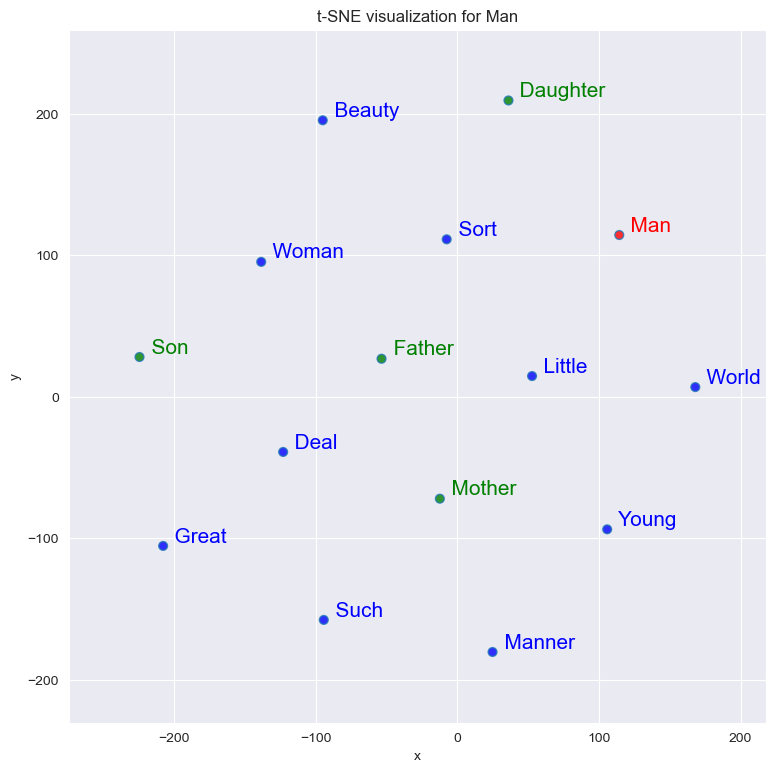

In [22]:
# 'man'과 유사한 단어 plotting & 직접 단어 지정 가능
tsnescatterplot(model, 'man', ['father','mother','son','daughter'])

## Word2Vec 모델 저장하고 불러오기

In [23]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [24]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('young', 0.9842323660850525), ('woman', 0.9831780791282654), ('sort', 0.9799663424491882), ('great', 0.9733275771141052), ('little', 0.9708943367004395), ('world', 0.9700031876564026), ('such', 0.9691986441612244), ('deal', 0.9680957794189453), ('beauty', 0.9667670726776123), ('manner', 0.9661726951599121)]


# 연습문제

<span style = 'font-size:1.3em;line-height:1.5em'><b>1.</b> scikit learn의 20 news group dataset을 활용하여 word2vec모델을 학습해보세요. </span>
- <span style = 'font-size:1.2em;line-height:1.5em'> Tokenize때 nltk.RegexpTokenizer("[a-zA-Z]+")를 사용하세요. 더 좋은 방법이 있으신 분들은 다른 정규 표현식을 사용하셔도 좋습니다. </span>


In [25]:
from sklearn.datasets import fetch_20newsgroups

In [26]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print(len(documents))# 총 11314개의 문서

11314


In [27]:
# 여기서부터 코드를 작성해주세요

# tokenize 룰 정의 
reg_tokenizer = nltk.RegexpTokenizer("[a-zA-Z]+") 

# 위에서 진행한 tokenize 방법 적용
corpus_tokens = [] # 전체 토큰 리스트
for document in documents:
    document = document.lower()
    tokens = reg_tokenizer.tokenize(document)
    sentence_tokens = tokens

    corpus_tokens.append(sentence_tokens)

In [28]:
print(corpus_tokens[0:3])

[['well', 'i', 'm', 'not', 'sure', 'about', 'the', 'story', 'nad', 'it', 'did', 'seem', 'biased', 'what', 'i', 'disagree', 'with', 'is', 'your', 'statement', 'that', 'the', 'u', 's', 'media', 'is', 'out', 'to', 'ruin', 'israels', 'reputation', 'that', 'is', 'rediculous', 'the', 'u', 's', 'media', 'is', 'the', 'most', 'pro', 'israeli', 'media', 'in', 'the', 'world', 'having', 'lived', 'in', 'europe', 'i', 'realize', 'that', 'incidences', 'such', 'as', 'the', 'one', 'described', 'in', 'the', 'letter', 'have', 'occured', 'the', 'u', 's', 'media', 'as', 'a', 'whole', 'seem', 'to', 'try', 'to', 'ignore', 'them', 'the', 'u', 's', 'is', 'subsidizing', 'israels', 'existance', 'and', 'the', 'europeans', 'are', 'not', 'at', 'least', 'not', 'to', 'the', 'same', 'degree', 'so', 'i', 'think', 'that', 'might', 'be', 'a', 'reason', 'they', 'report', 'more', 'clearly', 'on', 'the', 'atrocities', 'what', 'is', 'a', 'shame', 'is', 'that', 'in', 'austria', 'daily', 'reports', 'of', 'the', 'inhuman', 'act

In [29]:


# model 선언 
'''
sentences : token list
vector_size : 단어vector 크기
window : window 크기 
sg : 0->CBOW, 1->skip-gram
'''
model = Word2Vec(sentences=corpus_tokens, vector_size=100, window=5, min_count=5, workers=4, sg=0)

In [26]:
# 'man'과 유사한 단어 출력
# 출력 -> ('단어 token', 유사도)
model_result = model.wv.most_similar('man')

In [27]:
print(model_result)

[('woman', 0.8469898104667664), ('himself', 0.802811861038208), ('jesus', 0.7799671292304993), ('son', 0.7672330141067505), ('judas', 0.7602532505989075), ('person', 0.7577089071273804), ('father', 0.7516959309577942), ('christ', 0.7496441006660461), ('prophet', 0.7323084473609924), ('muhammad', 0.7307524085044861)]


/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


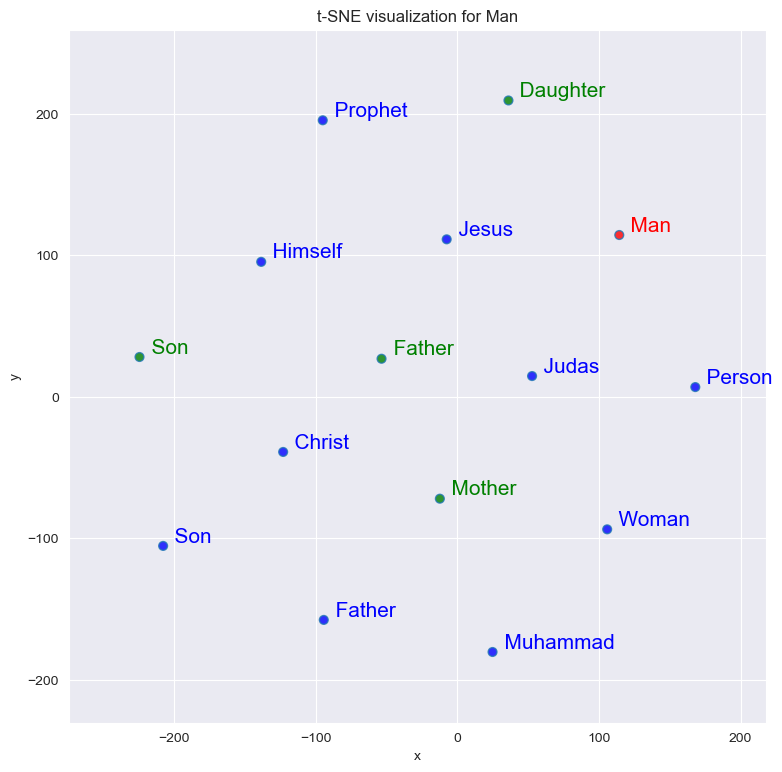

In [28]:
# visualization
# 'man'과 유사한 단어 plotting & 직접 단어 지정 가능
tsnescatterplot(model, 'man', ['father','mother','son','daughter'])

---

# 2. Pretrained된 word2vec사용하기

## 주의: 파일의 크기가 꽤 큽니다.
## 다운로드 받을 때나 사용하실 때 주의하세요

In [29]:
# Full version
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

/Users/jimin/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


### Simple version
https://github.com/eyaler/word2vec-slim/blob/master/GoogleNews-vectors-negative300-SLIM.bin.gz

In [30]:
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [31]:
import gensim

In [32]:
%%time
googleNews_filepath = os.path.join('./',data_dir, "GoogleNews-vectors-negative300-SLIM.bin")
print(f"== {googleNews_filepath} load as word2vec model start")
GoogleSlimModel = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format(
    googleNews_filepath, binary=True
)

== ./data/GoogleNews-vectors-negative300-SLIM.bin load as word2vec model start
CPU times: user 1.05 s, sys: 81.8 ms, total: 1.13 s
Wall time: 1.13 s


In [33]:
GoogleSlimModel.most_similar('car', topn=20)

[('vehicle', 0.7821096181869507),
 ('cars', 0.7423830628395081),
 ('SUV', 0.7160962820053101),
 ('minivan', 0.6907036304473877),
 ('truck', 0.6735790371894836),
 ('Car', 0.6677609086036682),
 ('Jeep', 0.651133120059967),
 ('scooter', 0.6381529569625854),
 ('sedan', 0.6336701512336731),
 ('motorcycle', 0.6256054639816284),
 ('van', 0.6115673184394836),
 ('Corvette', 0.6078192591667175),
 ('Mercedes', 0.6063582301139832),
 ('suv', 0.605436384677887),
 ('vehicles', 0.5998871326446533),
 ('motorbike', 0.5921168923377991),
 ('Camaro', 0.5906863212585449),
 ('bike', 0.5854154229164124),
 ('automobile', 0.5838367938995361),
 ('BMW', 0.5806986689567566)]

In [36]:
# t-SNE로 시각화 하기 위한 함수
# original Code inspired from  https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
def tsnescatterplot2(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, model.vector_size), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    #arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    arrays = np.append(arrays, model.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    #close_words = model.wv.most_similar([word])
    close_words = model.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        #wrd_vector = model.wv.__getitem__([wrd_score[0]])
        wrd_vector = model.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        #wrd_vector = model.wv.__getitem__([wrd])
        wrd_vector = model.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from vector_size to 10 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


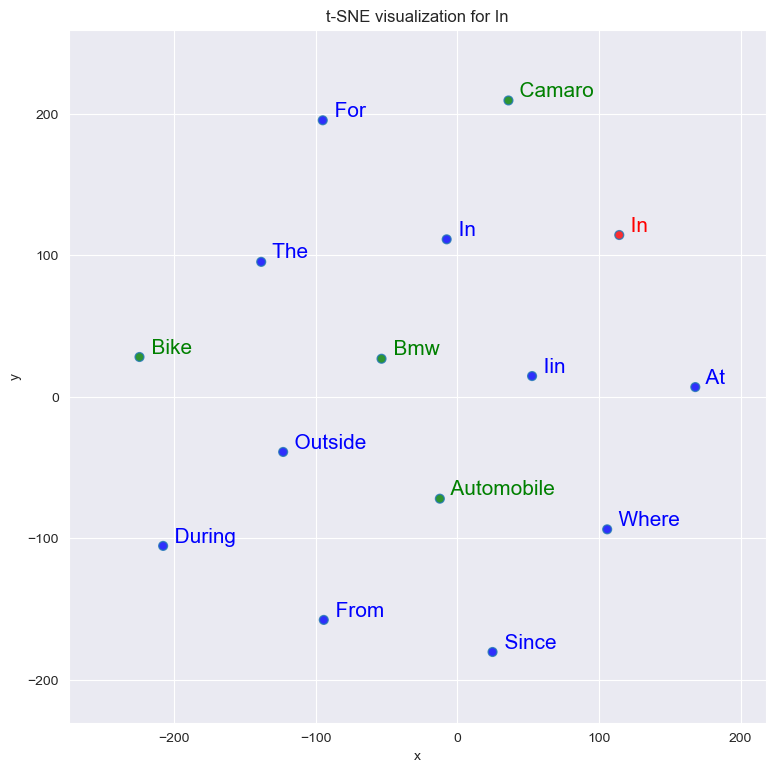

In [37]:
tsnescatterplot2(GoogleSlimModel, 'in', ['BMW','automobile','bike','Camaro'])

In [41]:
GoogleSlimModel.index_to_key

['in',
 'for',
 'that',
 'is',
 'on',
 'The',
 'with',
 'said',
 'was',
 'the',
 'at',
 'not',
 'as',
 'it',
 'be',
 'from',
 'by',
 'are',
 'I',
 'have',
 'he',
 'will',
 'has',
 'his',
 'an',
 'this',
 'or',
 'their',
 'who',
 'they',
 'but',
 'had',
 'year',
 'were',
 'we',
 'more',
 'up',
 'been',
 'you',
 'its',
 'one',
 'about',
 'would',
 'which',
 'out',
 'can',
 'It',
 'all',
 'also',
 'two',
 'after',
 'first',
 'He',
 'do',
 'time',
 'than',
 'when',
 'We',
 'over',
 'last',
 'new',
 'other',
 'her',
 'people',
 'into',
 'In',
 'our',
 'there',
 'A',
 'she',
 'could',
 'just',
 'years',
 'some',
 'U.S.',
 'three',
 'million',
 'them',
 'what',
 'But',
 'so',
 'no',
 'like',
 'if',
 'only',
 'percent',
 'get',
 'did',
 'him',
 'game',
 'back',
 'because',
 'now',
 'before',
 'company',
 'any',
 'team',
 'against',
 'off',
 'This',
 'most',
 'made',
 'through',
 'make',
 'second',
 'state',
 'well',
 'day',
 'season',
 'says',
 'week',
 'where',
 'while',
 'down',
 'being',
 '

## Pretrained된 벡터 시각화(from tensorflow)

https://projector.tensorflow.org/

# 연습문제

<span style = 'font-size:1.3em;line-height:1.5em'><b>1.</b> Tensorflow projector을 사용하기 위해 https://wikidocs.net/50704 를 참고하여 학습한 벡터를 넣고 visualize 해봅시다. 여러분이 따로 학습한 벡터여도 좋고, 바로 위의 실습문제에서 한 SlimModel을 사용하셔도 좋습니다. 시각화한 결과를 공유해주세요.</span>


In [39]:
!python -m gensim.scripts.word2vec2tensor --input eng_w2v --output eng_w2v

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2022-11-23 14:25:52,631 - word2vec2tensor - INFO - running /opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.8/site-packages/gensim/scripts/word2vec2tensor.py --input eng_w2v --output eng_w2v
2022-11-23 14:25:52,631 - keyedvectors - INFO - loading projection weights from eng_w2v
2022-11-23 14:25:52,704 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (2344, 100) matrix of type float32 from eng_w2v', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-11-23T14:25:52.697362', 'gensim': '4.2.0', 'python': '3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:21:17) \n[Clang 11.1.0 ]', 'platform': 'macOS-12.3.1-arm64-arm-64bit', 'event': 'load_word2vec_format'}
2022-11-23 14:25:52,790 - word2vec2tensor - INFO - 2D tensor file saved to eng_w2v_tensor.tsv
2022-11-23 14:25

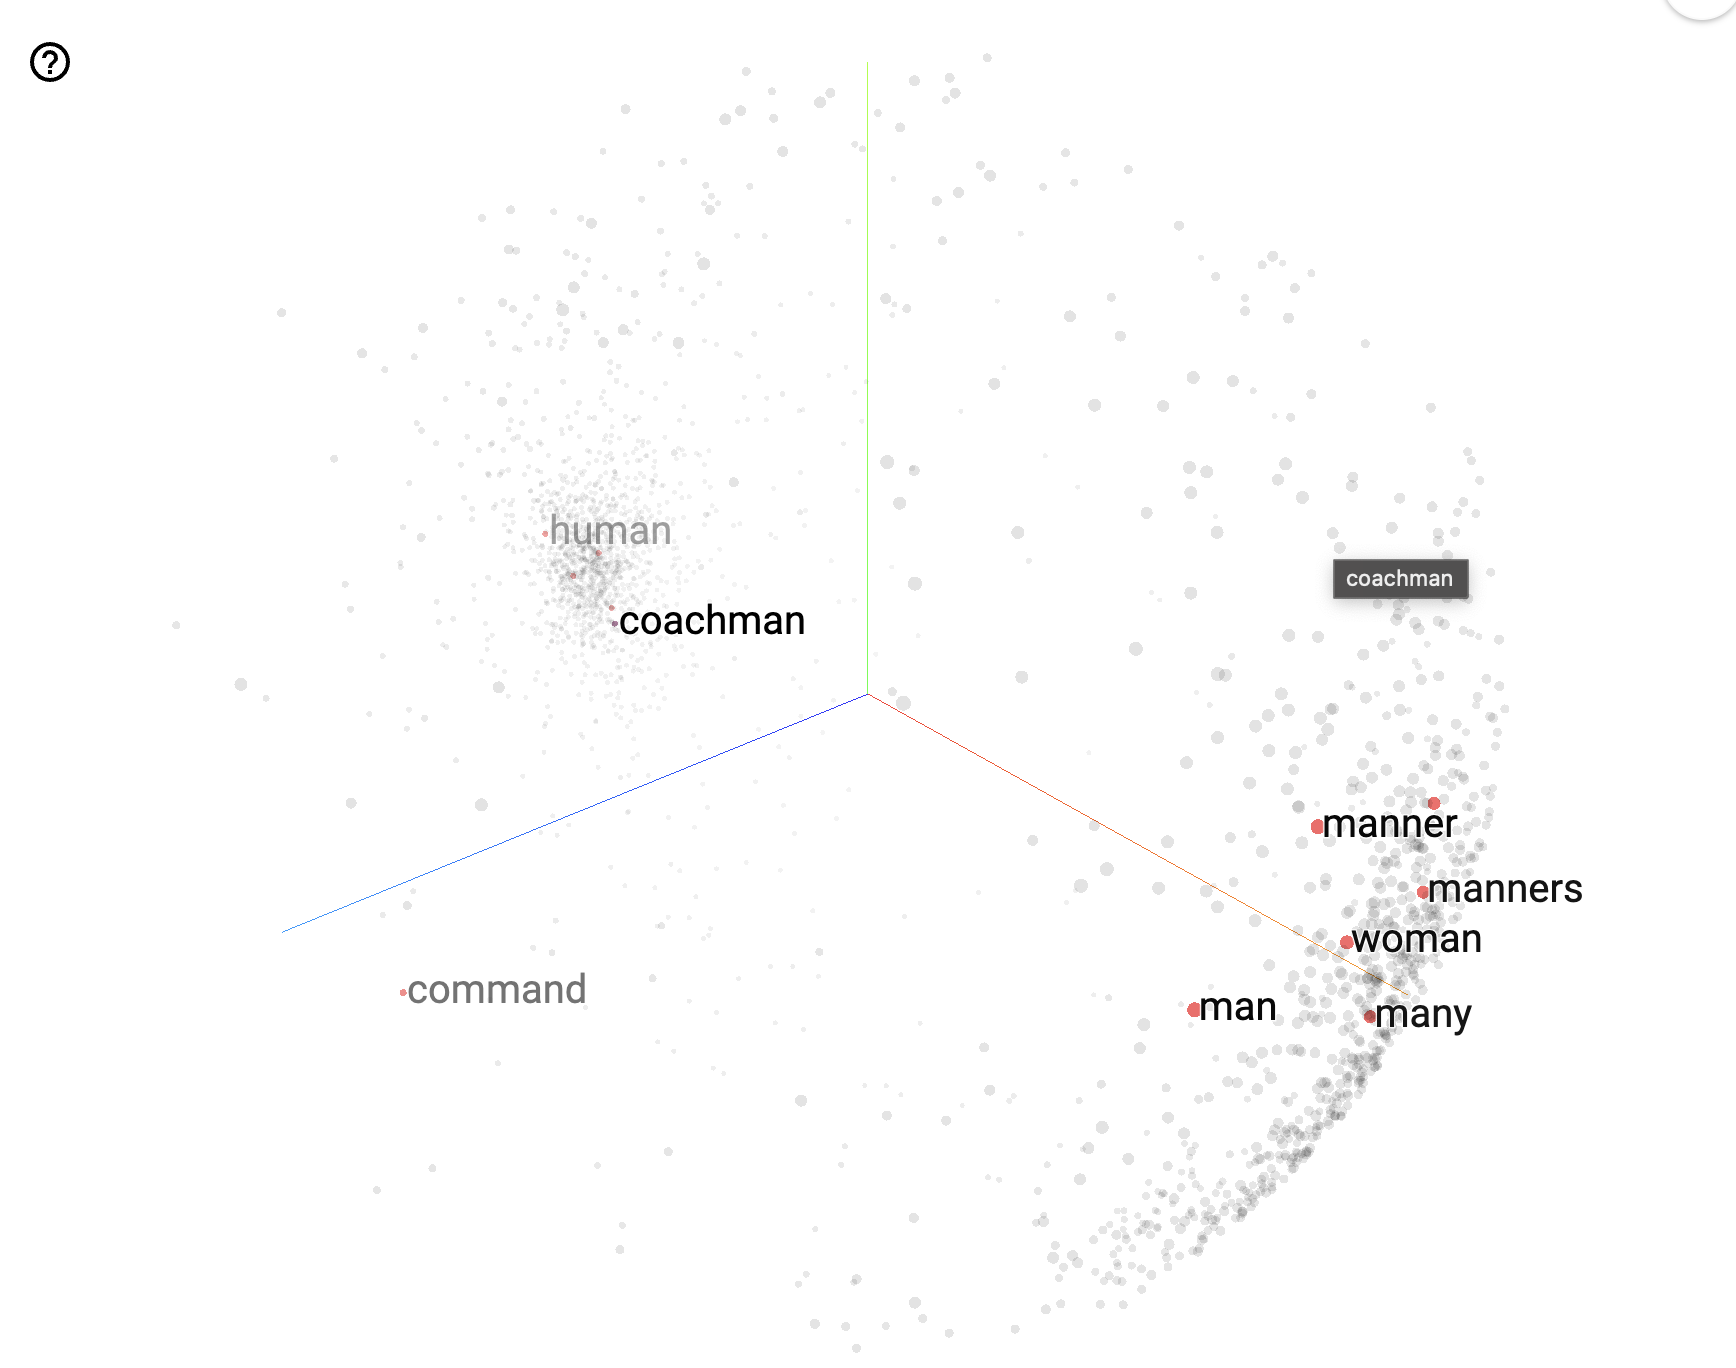

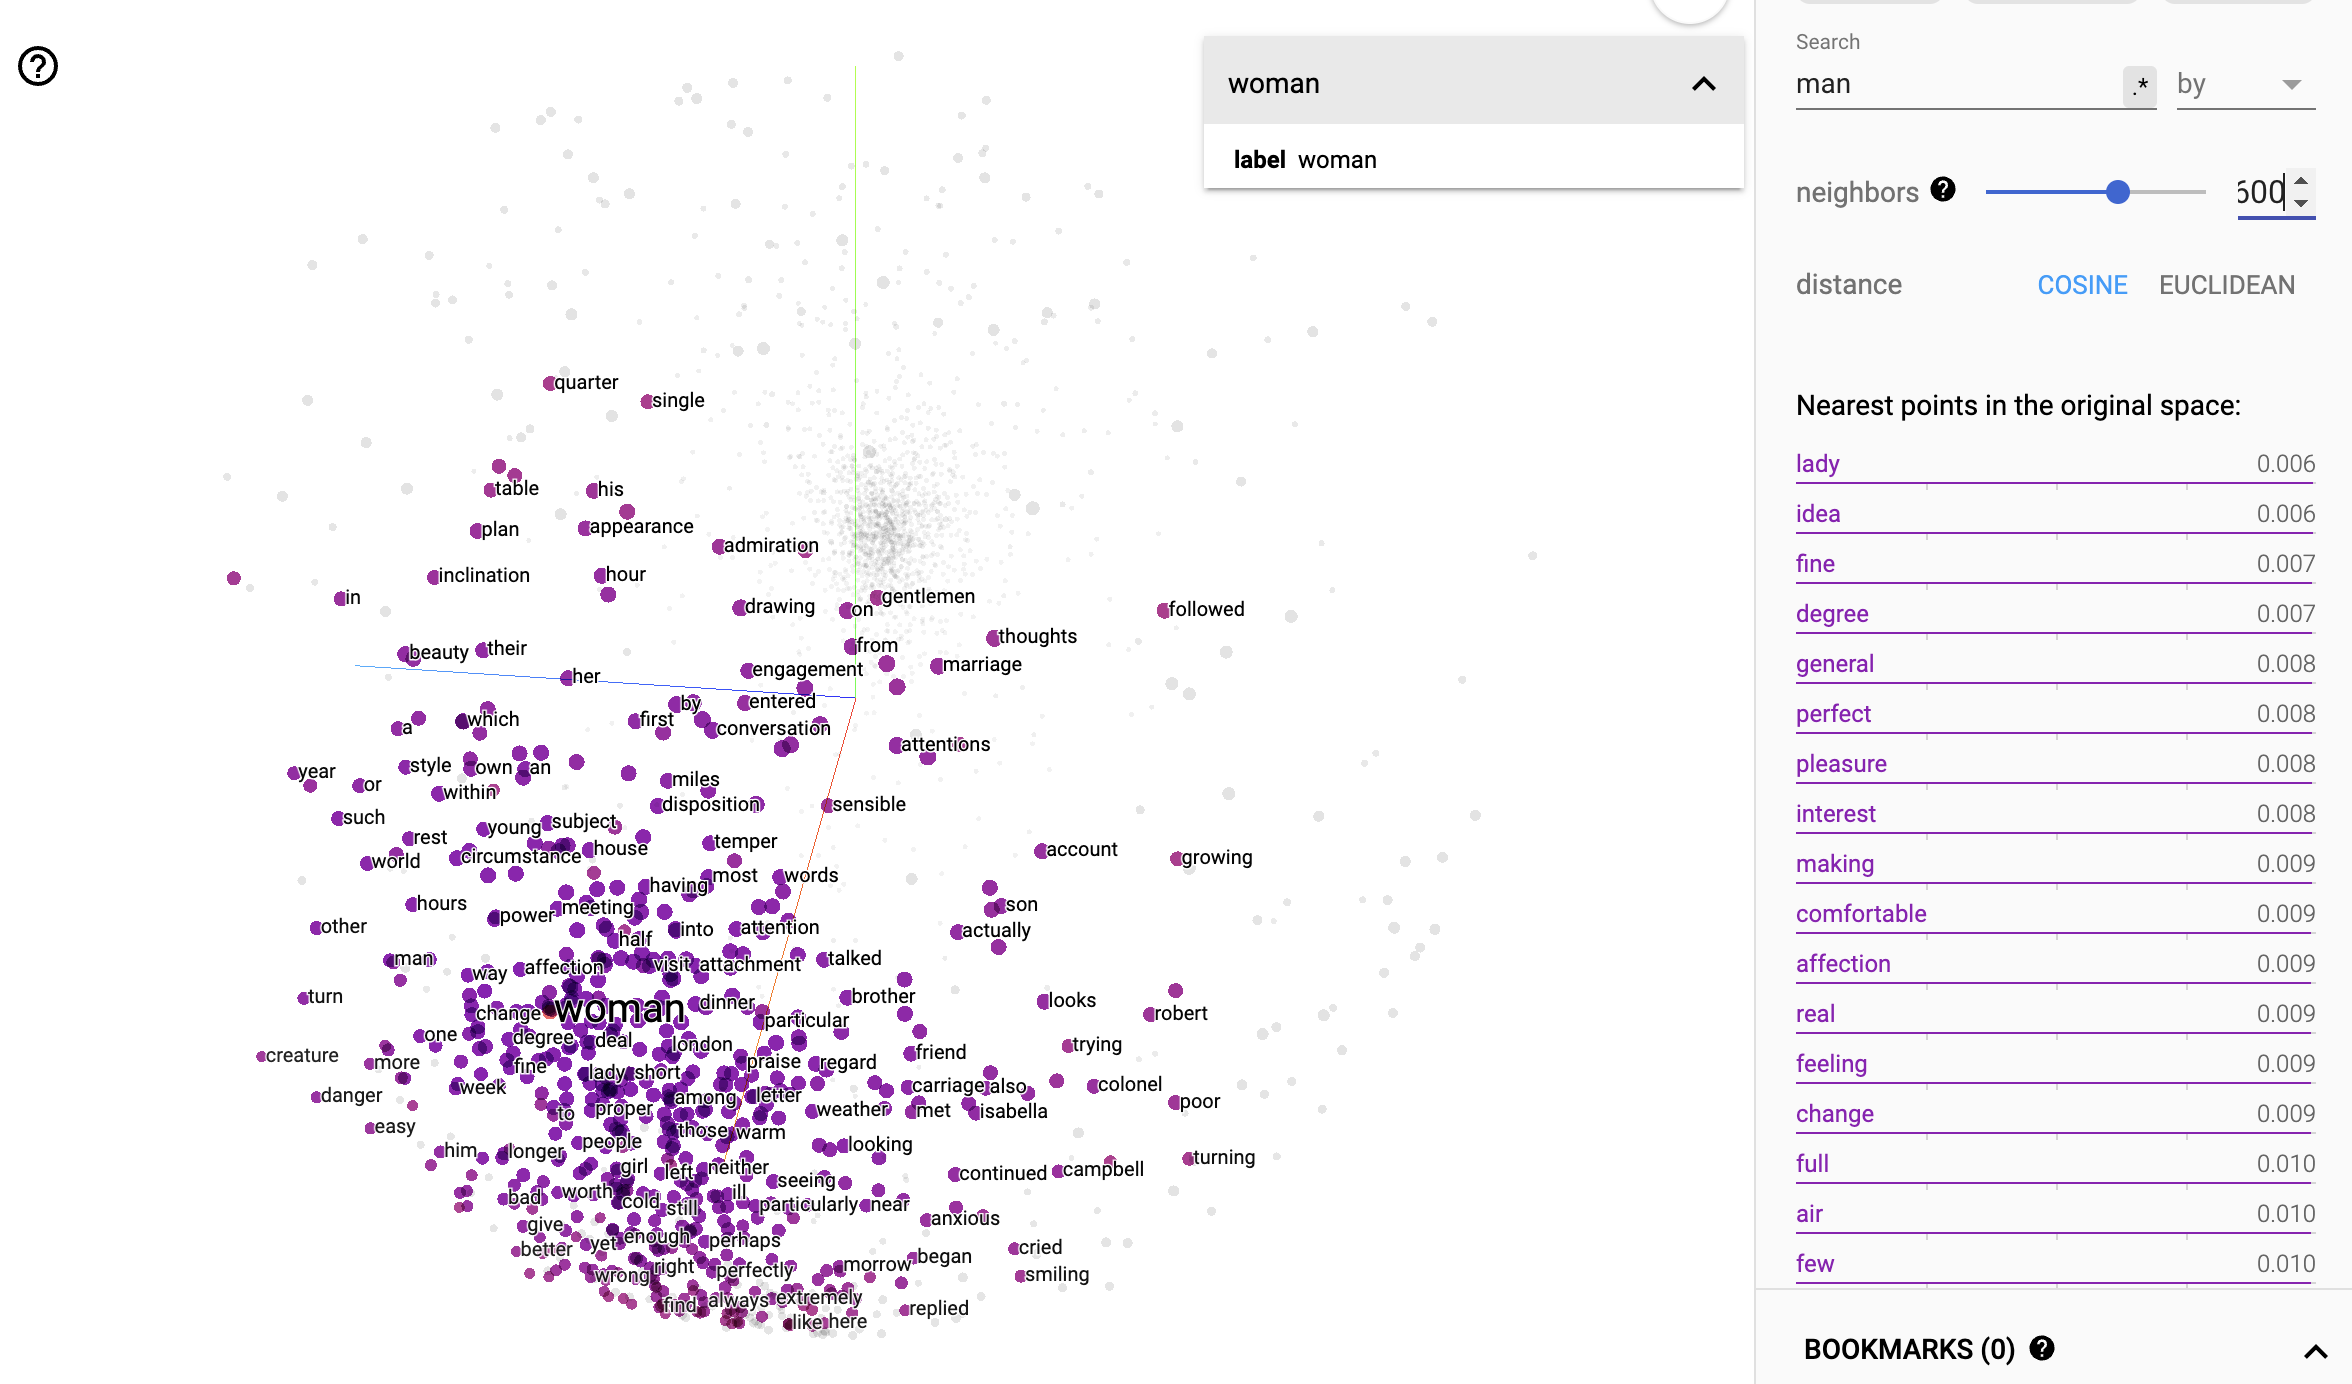